In [40]:
%pip install --upgrade --user google-cloud-aiplatform pymupdf rich colorama

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./key.json"
# %system ~/google-cloud-sdk/bin/gcloud auth application-default login

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
google_project_id = os.getenv('GOOGLE_PROJECT_ID')
google_location = "europe-west1"

In [4]:
import vertexai
vertexai.init(project=google_project_id, location=google_location)

In [5]:
from IPython.display import Markdown, display
from rich.markdown import Markdown as rich_Markdown
from vertexai.generative_models import GenerationConfig, GenerativeModel, Image

text_model = GenerativeModel("gemini-1.5-pro")
multimodal_model = GenerativeModel("gemini-1.5-pro")
multimodal_model_flash = GenerativeModel("gemini-1.5-flash")


In [6]:
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

In [10]:
from helpers import get_document_metadata

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,
    './pdf',
    image_save_dir="./images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)



 Processing the file: --------------------------------- ./pdf/epam-report.pdf 


Processing page: 1
Extracting image from page: 1, saved as: ./images/epam-report.pdf_image_0_0_9.jpeg
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5


In [11]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,epam-report.pdf,1,"V I E W A L L N E W S\nD ATE\nNovember 7, 20...","[-0.019254421815276146, -0.026206426322460175,...",1,"V I E W A L L N E W S\nD ATE\nNovember 7, 20...","[-0.01310722902417183, -0.013363610953092575, ..."
1,epam-report.pdf,1,"V I E W A L L N E W S\nD ATE\nNovember 7, 20...","[-0.019254421815276146, -0.026206426322460175,...",2,"PAM Systems, Inc. (NYSE: EPAM), a leading digi...","[-0.001168870716355741, -0.05384514853358269, ..."
2,epam-report.pdf,1,"V I E W A L L N E W S\nD ATE\nNovember 7, 20...","[-0.019254421815276146, -0.026206426322460175,...",3,uarter of 2023;\nWe recorded a benefit of $52....,"[-0.01423549372702837, -0.026544077321887016, ..."
3,epam-report.pdf,1,"V I E W A L L N E W S\nD ATE\nNovember 7, 20...","[-0.019254421815276146, -0.026206426322460175,...",4,"ion, an increase of $63.0 million, or 55.2%, c...","[-0.009012407623231411, -0.01399849634617567, ..."
4,epam-report.pdf,1,"V I E W A L L N E W S\nD ATE\nNovember 7, 20...","[-0.019254421815276146, -0.026206426322460175,...",5,ncrease to the effective tax rate;\nNon-GAAP d...,"[-0.005996230058372021, -0.01537022739648819, ..."


In [12]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,epam-report.pdf,1,1,./images/epam-report.pdf_image_0_0_9.jpeg,The image presents a financial report from EPA...,"[-0.00892232917, 0.015445943, 0.00693804584, -...","[-0.018329229205846786, -0.003188361646607518,..."


In [21]:
from helpers import (
    display_images,
    get_gemini_response,
    get_similar_image_from_query,
    get_similar_text_from_query,
    print_text_to_image_citation,
    print_text_to_text_citation,
)

query = "I need details on basic and diluted net income for EPAM per share?"

matching_results_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=6,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(matching_results_text, print_top=False, chunk_text=True)

Citation 1: Matched text: 

score:  0.76
file_name:  epam-report.pdf
page_number:  1
chunk_number:  1
chunk_text:  V I E W  A L L  N E W S
D ATE
November 7, 2024
Third quarter revenues of $1.168 billion, up 1.3% year-over-year
GAAP income from operations was 15.2% of revenues and non-GAAP income from operations was 19.1% of revenues for the third quarter
Third quarter GAAP diluted EPS of $2.37, an increase of $0.72, and non-GAAP diluted EPS of $3.12, an increase of $0.39 on a year-over-year
basis
For the full year, EPAM increases expected range for revenues to now be $4.685 billion to $4.695 billion, increases expected GAAP diluted
EPS to now be in the range of $7.78 to $7.86 and non-GAAP diluted EPS to now be in the range of $10.73 to $10.81
For the fourth quarter, EPAM expects revenues to be in the range of $1.205 billion to $1.215 billion, GAAP diluted EPS to be in the range of
$1.73 to $1.81 and non-GAAP diluted EPS to be in the range of $2.70 to $2.78
NEWTOWN, Pa., Nov. 7, 2024 /P

In [23]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = "\n".join(
    [value["chunk_text"] for key, value in matching_results_text.items()]
)

instruction = f"""Answer the question with the given context.
If the information is not available in the context, just return "not available in the context".
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
get_gemini_response(
    text_model,  # we are passing Gemini 1.0 Pro
    model_input=model_input,
    stream=True,
    generation_config=GenerationConfig(temperature=0.5),
)


 **** Result: ***** 



'The basic net income per share for EPAM was $2.40 and the diluted net income per share was $2.37 for the three months ended September 30, 2024. \n'


 **** Result: ***** 



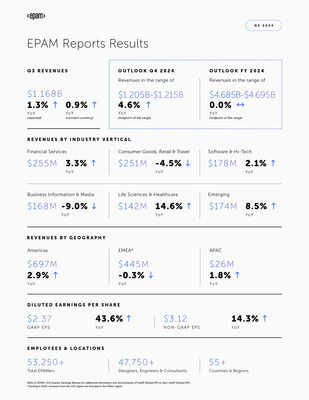

In [24]:
matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display(matching_results_image[0]["image_object"])

In [25]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = f"""Image: {matching_results_image[0]['image_object']}
Description: {matching_results_image[0]['image_description']}
"""

instruction = f"""Answer the question in JSON format with the given context of Image and its Description. Only include value.
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model_flash,  # we are passing Gemini 1.5 Pro Flash
        model_input=model_input,
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)


 **** Result: ***** 



```json
{
 "GAAP EPS": 2.37,
 "Non-GAAP EPS": 3.12
}
```

In [26]:
## you can check the citations to probe further.
## check the "image description:" which is a description extracted through Gemini which helped search our query.
Markdown(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1: Matched image path, page number and page text: 

score:  0.74
file_name:  epam-report.pdf
path:  ./images/epam-report.pdf_image_0_0_9.jpeg
page number:  1
page text:  V I E W  A L L  N E W S
D ATE
November 7, 2024
Third quarter revenues of $1.168 billion, up 1.3% year-over-year
GAAP income from operations was 15.2% of revenues and non-GAAP income from operations was 19.1% of revenues for the third quarter
Third quarter GAAP diluted EPS of $2.37, an increase of $0.72, and non-GAAP diluted EPS of $3.12, an increase of $0.39 on a year-over-year
basis
For the full year, EPAM increases expected range for revenues to now be $4.685 billion to $4.695 billion, increases expected GAAP diluted
EPS to now be in the range of $7.78 to $7.86 and non-GAAP diluted EPS to now be in the range of $10.73 to $10.81
For the fourth quarter, EPAM expects revenues to be in the range of $1.205 billion to $1.215 billion, GAAP diluted EPS to be in the range of
$1.73 to $1.81 and non-GAAP diluted EPS to

<IPython.core.display.Markdown object>

***Input image from user:***


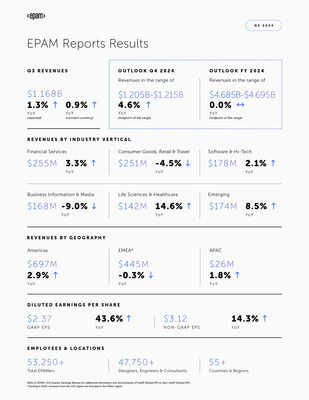

In [29]:
image_query_path = "./images/epam-report.pdf_image_0_0_9.jpeg"

# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)

In [31]:
matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,  # Use query text for additional filtering (optional)
    column_name="mm_embedding_from_img_only",  # Use image embedding for similarity calculation
    image_emb=True,
    image_query_path=image_query_path,  # Use input image for similarity calculation
    top_n=3,  # Retrieve top 3 matching images
    embedding_size=1408,  # Use embedding size of 1408
)
matching_results_image

{}


 **** Result: ***** 



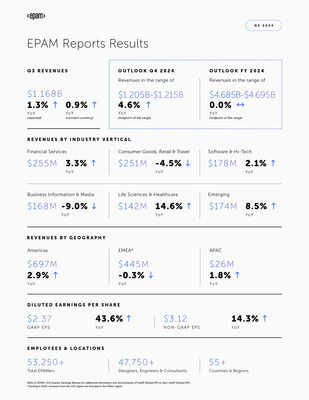

In [34]:
matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display(matching_results_image[0]["image_object"])

In [35]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = f"""Image: {matching_results_image[0]['image_object']}
Description: {matching_results_image[0]['image_description']}
"""

instruction = f"""Answer the question in JSON format with the given context of Image and its Description. Only include value.
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model_flash,  # we are passing Gemini 1.5 Pro Flash
        model_input=model_input,
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)


 **** Result: ***** 



```json
{
 "basic_net_income_per_share": null,
 "diluted_net_income_per_share": 2.37
}
```

In [36]:
Markdown(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1: Matched image path, page number and page text: 

score:  0.74
file_name:  epam-report.pdf
path:  ./images/epam-report.pdf_image_0_0_9.jpeg
page number:  1
page text:  V I E W  A L L  N E W S
D ATE
November 7, 2024
Third quarter revenues of $1.168 billion, up 1.3% year-over-year
GAAP income from operations was 15.2% of revenues and non-GAAP income from operations was 19.1% of revenues for the third quarter
Third quarter GAAP diluted EPS of $2.37, an increase of $0.72, and non-GAAP diluted EPS of $3.12, an increase of $0.39 on a year-over-year
basis
For the full year, EPAM increases expected range for revenues to now be $4.685 billion to $4.695 billion, increases expected GAAP diluted
EPS to now be in the range of $7.78 to $7.86 and non-GAAP diluted EPS to now be in the range of $10.73 to $10.81
For the fourth quarter, EPAM expects revenues to be in the range of $1.205 billion to $1.215 billion, GAAP diluted EPS to be in the range of
$1.73 to $1.81 and non-GAAP diluted EPS to

<IPython.core.display.Markdown object>

***Input image from user:***


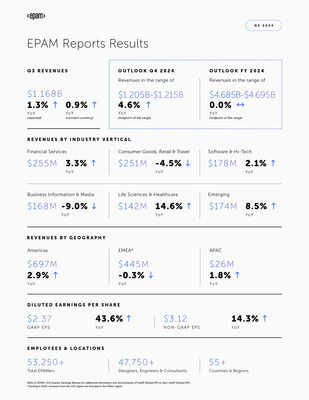

In [37]:
# You can find a similar image as per the images you have in the metadata.
# In this case, you have a table (picked from the same document source) and you would like to find similar tables in the document.
# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)

In [41]:
matching_results_image_query_1 = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query="Show me all the graphs that shows EPAM cumulative 1-year total return",
    column_name="text_embedding_from_image_description",  # Use image description text embedding # mm_embedding_from_img_only text_embedding_from_image_description
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)
matching_results_image_query_1

{0: {'cosine_score': 0.67,
  'image_object': <vertexai.generative_models._generative_models.Image at 0x1649a85b0>,
  'file_name': 'epam-report.pdf',
  'img_path': './images/epam-report.pdf_image_0_0_9.jpeg',
  'page_num': 1,
  'page_text': array(['V I E W  A L L  N E W S\nD ATE\nNovember 7, 2024\nThird quarter revenues of $1.168 billion, up 1.3% year-over-year\nGAAP income from operations was 15.2% of revenues and non-GAAP income from operations was 19.1% of revenues for the third quarter\nThird quarter GAAP diluted EPS of $2.37, an increase of $0.72, and non-GAAP diluted EPS of $3.12, an increase of $0.39 on a year-over-year\nbasis\nFor the full year, EPAM increases expected range for revenues to now be $4.685 billion to $4.695 billion, increases expected GAAP diluted\nEPS to now be in the range of $7.78 to $7.86 and non-GAAP diluted EPS to now be in the range of $10.73 to $10.81\nFor the fourth quarter, EPAM expects revenues to be in the range of $1.205 billion to $1.215 billion, GAA

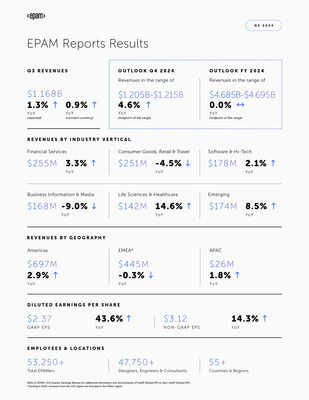

In [44]:
matching_results_image_query_1[0]["image_object"]

In [43]:
prompt = f""" Instructions: Compare the images and the Gemini extracted text provided as Context: to answer Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.

Context:
Image_1: {matching_results_image_query_1[0]["image_object"]}
gemini_extracted_text_1: {matching_results_image_query_1[0]['image_description']}

Question:
 - Key findings of EPAM share?
 - What are the key findings of EPAM shares concerning the S&P 500?
 - Which index best matches EPAM share performance closely where Google is not already a part? Explain the reasoning.
 - Identify key chart patterns in both graphs.
 - Which index best matches EPAM share performance closely where Google is not already a part? Explain the reasoning.
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,  # we are passing Gemini 1.5 Pro
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)

I apologize, but I cannot answer your question without access to Image_1 and its associated data points. The       
provided context only offers textual information from the image, lacking visual cues like historical stock prices  
or comparisons with the S&P 500.                                                                                   

To effectively address your question and provide a comprehensive analysis, I need access to the visual             
representation of EPAM share performance data as depicted in Image_1.                                              

Please provide me with the chart or a description of the data points visible in Image_1.

In [46]:
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)
matching_results_chunks_data

{0: {'file_name': 'epam-report.pdf',
  'page_num': 1,
  'cosine_score': 0.76,
  'chunk_number': 1,
  'chunk_text': 'V I E W  A L L  N E W S\nD ATE\nNovember 7, 2024\nThird quarter revenues of $1.168 billion, up 1.3% year-over-year\nGAAP income from operations was 15.2% of revenues and non-GAAP income from operations was 19.1% of revenues for the third quarter\nThird quarter GAAP diluted EPS of $2.37, an increase of $0.72, and non-GAAP diluted EPS of $3.12, an increase of $0.39 on a year-over-year\nbasis\nFor the full year, EPAM increases expected range for revenues to now be $4.685 billion to $4.695 billion, increases expected GAAP diluted\nEPS to now be in the range of $7.78 to $7.86 and non-GAAP diluted EPS to now be in the range of $10.73 to $10.81\nFor the fourth quarter, EPAM expects revenues to be in the range of $1.205 billion to $1.215 billion, GAAP diluted EPS to be in the range of\n$1.73 to $1.81 and non-GAAP diluted EPS to be in the range of $2.70 to $2.78\nNEWTOWN, Pa., Nov

In [48]:
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)
matching_results_image_fromdescription_data

{0: {'cosine_score': 0.74,
  'image_object': <vertexai.generative_models._generative_models.Image at 0x164a70880>,
  'file_name': 'epam-report.pdf',
  'img_path': './images/epam-report.pdf_image_0_0_9.jpeg',
  'page_num': 1,
  'page_text': array(['V I E W  A L L  N E W S\nD ATE\nNovember 7, 2024\nThird quarter revenues of $1.168 billion, up 1.3% year-over-year\nGAAP income from operations was 15.2% of revenues and non-GAAP income from operations was 19.1% of revenues for the third quarter\nThird quarter GAAP diluted EPS of $2.37, an increase of $0.72, and non-GAAP diluted EPS of $3.12, an increase of $0.39 on a year-over-year\nbasis\nFor the full year, EPAM increases expected range for revenues to now be $4.685 billion to $4.695 billion, increases expected GAAP diluted\nEPS to now be in the range of $7.78 to $7.86 and non-GAAP diluted EPS to now be in the range of $10.73 to $10.81\nFor the fourth quarter, EPAM expects revenues to be in the range of $1.205 billion to $1.215 billion, GAA

In [50]:
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

context_images

['Image: ',
 'Caption: ',
 'The image presents a financial report from EPAM, detailing their Q1 2024 earnings results, as well as their outlooks for Q4 2024 and the full fiscal year 2024.\n\n**Key Highlights:**\n\n* **Q1 Revenues:** $1.168B, representing a 1.3% increase year-over-year (YoY) and a 0.9% increase compared to the previous quarter.\n* **Outlook Q4 2024:** Projected revenue between $1.205B and $1.215B, indicating a potential 4.6% YoY increase.\n* **Outlook FY 2024:** Anticipated revenue in the range of $4.685B to $4.695B, suggesting a flat growth compared to the previous fiscal year.\n\n**Revenues by Industry Vertical:**\n\n* **Financial Services:** $255M, a 3.3% YoY increase.\n* **Consumer Goods, Retail & Travel:** $251M, a 4.5% YoY decrease.\n* **Software & Hi-Tech:** $178M, a 2.1% YoY increase.\n* **Business Information & Media:** $168M, a 9.0% YoY decrease.\n* **Life Sciences & Healthcare:** $142M, a 14.6% YoY increase.\n* **Emerging:** $174M, an 8.5% YoY increase.\n\n**

In [51]:
prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}

{query}

Answer:
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)

The text provides the following information about EPAM's basic and diluted net income per share:                   

 • Third Quarter 2024:                                                                                             
    • Basic net income per share: $2.40                                                                            
    • Diluted net income per share: $2.37                                                                          
 • Third Quarter 2023:                                                                                             
    • Basic net income per share: $1.68                                                                            
    • Diluted net income per share: $1.65                                                                          
 • Nine Months Ended September 30, 2024:                                                                           
    • Basic net income per share: $6.11                                                                            
    • Diluted net income per share: $6.04                                                                          
 • Nine Months Ended September 30, 2023:                                                                           
    • Basic net income per share: $5.52                                                                            
    • Diluted net income per share: $5.40                                                                          

The image caption does not provide details on basic and diluted net income per share.

In [52]:
print_text_to_image_citation(
    matching_results_image_fromdescription_data, print_top=False
)

Citation 1: Matched image path, page number and page text: 

score:  0.74
file_name:  epam-report.pdf
path:  ./images/epam-report.pdf_image_0_0_9.jpeg
page number:  1
page text:  V I E W  A L L  N E W S
D ATE
November 7, 2024
Third quarter revenues of $1.168 billion, up 1.3% year-over-year
GAAP income from operations was 15.2% of revenues and non-GAAP income from operations was 19.1% of revenues for the third quarter
Third quarter GAAP diluted EPS of $2.37, an increase of $0.72, and non-GAAP diluted EPS of $3.12, an increase of $0.39 on a year-over-year
basis
For the full year, EPAM increases expected range for revenues to now be $4.685 billion to $4.695 billion, increases expected GAAP diluted
EPS to now be in the range of $7.78 to $7.86 and non-GAAP diluted EPS to now be in the range of $10.73 to $10.81
For the fourth quarter, EPAM expects revenues to be in the range of $1.205 billion to $1.215 billion, GAAP diluted EPS to be in the range of
$1.73 to $1.81 and non-GAAP diluted EPS to